<a href="https://colab.research.google.com/github/amolk/AGI-experiments/blob/master/2020-2/01_Retinotopic_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 1

In [10]:
%%writefile hp.py
import numpy
import math

class LayerHP:
  def __init__(self):
    self.input_shape = None
    self.output_shape = None

    self.alpha = 0.1   # learning rate
    self.alpha_n = 0.01 # neighbor learning rate
    
    self.enable_neighborhood_competition = False
    self.neighborhood_shape = (4, 4)

    # self.enable_neighborhood_smoothing = True
    # self.enable_precision = True
    # self.enable_precision_weighted_distance = True
    # self.enable_per_neuron_learning_rate = True
    # self.enable_retinotopy = True
    # self.retinotopic_local_grid_shape = (12, 12)

  @property
  def input_size(self):
    return numpy.prod(self.input_shape)

  @property
  def output_size(self):
    return numpy.prod(self.output_shape)

class DatasetHP:
  def __init__(self):
    self.image_batch_size = 2
    self.kernel_shape = (5, 5)
    self.patch_grid_shape = (10, 10)

  @property
  def kernel_size(self):
    return numpy.prod(self.kernel_shape)

  @property
  def patch_grid_size(self):
    return numpy.prod(self.patch_grid_shape)

class HP:
  def __init__(self):
    self.mask_contrast = 3


Overwriting hp.py


In [94]:
%%writefile util.py
import torch
import pdb
from hp import HP
from skimage.util.shape import view_as_windows

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Util:
  @staticmethod
  def add_gaussian_noise(tensor, mean=0., std=1.):
    t = tensor + torch.randn(tensor.size()).to(device) * std + mean
    t.to(device)
    return t

  @staticmethod
  def norm_scale(t):
    epsilon = 0.00001

    assert len(t.shape)==2, "t shape must be (batch,size)"
    # print("mean", t.mean())
    # print("std", t.std())
    std = t.std(dim=-1).unsqueeze(-1)
    std[std<epsilon] = epsilon
    t = (t - t.mean(dim=-1).unsqueeze(-1)) / std
    # print("max", t.max())
    # print("min", t.min())
    scale = (t.max(dim=-1)[0] - t.min(dim=-1)[0]).unsqueeze(-1)
    scale[scale<epsilon] = epsilon
    t = t / scale

    t = t - t.min(dim=-1)[0].unsqueeze(-1)
    # print("max", t.max())
    # print("min", t.min())

    return t

  @staticmethod
  def get_image_patch_indices(image_shape, kernel_shape, patch_grid_shape):
    assert len(image_shape) == 2, "Must be (image height, image width)"
    assert len(kernel_shape) == 2, "Only 2D kernels allowed"
    assert len(patch_grid_shape) == 2, "Only 2D patch grids allowed"

    image_height, image_width = image_shape
    kernel_height, kernel_width = kernel_shape
    patch_grid_height, patch_grid_width = patch_grid_shape

    # We will find patch top-left coordinates
    # First patch has top-left coordinates (0, 0)
    # Last patch has top-left coordinates (image_height - kernel_height)
    # (h, w)th patch has top-left coordinates
    #      (h / patch_grid_height) * (image_height - kernel_height) ,
    #      (w / patch_grid_width)  * (image_width  - kernel_width)

    indices_y, indices_x = torch.meshgrid(
        torch.linspace(0, image_height - kernel_height, patch_grid_height).long(),
        torch.linspace(0, image_width  - kernel_width,  patch_grid_width ).long()
    )
    return indices_y, indices_x

  @staticmethod
  def get_image_patches(image, config):
    image_as_windows = view_as_windows(image.numpy(), config.kernel_shape)
    return torch.from_numpy(image_as_windows[config.image_patch_indices_y, config.image_patch_indices_x]).to(device)

  @staticmethod
  def conv_slice(images, kernel_shape, stride):
    assert len(images.shape) == 3, "Must be (image count, image height, image width)"
    images = images.unsqueeze(1)

    fold_params = dict(kernel_size=kernel_shape, dilation=1, padding=0, stride=stride)
    unfold = torch.nn.Unfold(**fold_params)
    print("images", images.shape)
    unfolded = unfold(images)
    unfolded = unfolded.view(images.shape[0], -1, unfolded.shape[-1])
    unfolded = unfolded.transpose(1, 2)
    return unfolded

  @staticmethod
  def var_to_precision(pattern_var, hp):
    return torch.exp(-pattern_var * hp.mask_contrast)

Overwriting util.py


In [95]:
%%writefile graphics_util.py
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
from util import Util

class GraphicsUtil:
  @staticmethod
  def show_image_grid(images, alpha=None, vmin=0, vmax=1, grid_width=None, grid_height=None):
    assert len(images.shape) == 3, "Must be (image count, image height, image width)"
    (image_count, image_height, image_width) = images.shape

    if alpha is not None:
      assert images.shape == alpha.shape

    if grid_width is None or grid_height is None:
      image_grid_size = math.floor(image_count ** 0.5)
      if image_grid_size > 15:
        image_grid_size = 15

      images = images[0:image_grid_size*image_grid_size]
      if alpha is not None:
        alpha = alpha[0:image_grid_size*image_grid_size]

      grid_width = image_grid_size
      grid_height = image_grid_size
    else:
      assert grid_width * grid_height == image_count

    gutter_size = 2
    composite_image = torch.zeros(((image_height + gutter_size) * grid_height - gutter_size, (image_width + gutter_size) * grid_width - gutter_size))
    if alpha is not None:
      composite_alpha = torch.ones_like(composite_image)

    for row in range(grid_height):
      for col in range(grid_width):
        r1 = row * (image_height + gutter_size)
        r2 = r1 + image_height
        c1 = col * (image_width + gutter_size)
        c2 = c1 + image_width
        index = row * grid_height + col
        composite_image[r1:r2, c1:c2] = images[index] 
        if alpha is not None:
          composite_alpha[r1:r2, c1:c2] = alpha[index] 

    if alpha is None:
      composite_alpha = None

    plt.figure(figsize=(grid_height * 0.7, grid_width * 0.7))
    plt.imshow(composite_image.cpu().numpy(), alpha=composite_alpha, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.viridis)
    plt.axis('off')
    plt.show()



Overwriting graphics_util.py


In [96]:
%%writefile dataset_loader.py
from util import Util
from graphics_util import GraphicsUtil
import math
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def load_cifar10(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def load_imagefolder(batch_size=64):
  loader = torch.utils.data.DataLoader(
      datasets.ImageFolder('/content/drive/My Drive/work/datasets/digit',
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)
  
  return loader

def load_dataset(config):
  images = next(iter(load_mnist(batch_size=config.image_batch_size)))[0]
  images = images[:, 0, :, :]
  
  # plt.imshow(images[0].permute(1,2,0))
  # plt.show()

  ib, ih, iw = images.shape
  config.image_shape = (ih, iw)
  print("images", images.shape)

  plt.imshow(images[0], vmin=0, vmax=1)
  plt.show()

  image_patch_indices_y, image_patch_indices_x = Util.get_image_patch_indices(config.image_shape, config.kernel_shape, config.patch_grid_shape)

  config.image_patch_indices_y = image_patch_indices_y
  config.image_patch_indices_x = image_patch_indices_x

  image0_patches = Util.get_image_patches(images[0], config)
  GraphicsUtil.show_image_grid(image0_patches.view(-1, config.kernel_shape[0], config.kernel_shape[0]))

  dataset = torch.utils.data.TensorDataset(images)
  
  loader = torch.utils.data.DataLoader(dataset, batch_size=1, pin_memory=False)
  return loader, images

Overwriting dataset_loader.py


images torch.Size([2, 28, 28])


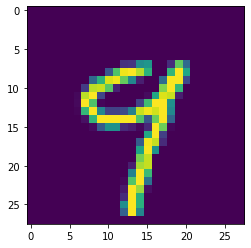

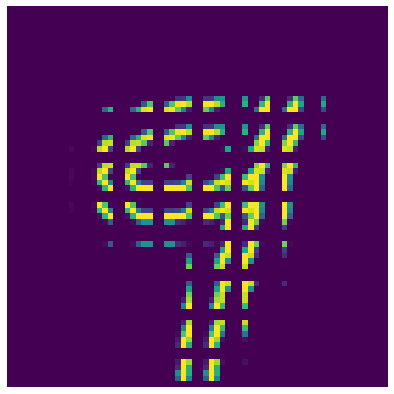

In [97]:
%aimport hp
%aimport util
%aimport graphics_util
%aimport dataset_loader

from hp import DatasetHP
from dataset_loader import load_dataset
from graphics_util import GraphicsUtil

dataset_hp = DatasetHP()
original_dataset, original_images = dataset_loader.load_dataset(dataset_hp)
# GraphicsUtil.show_image_grid(original_dataset.dataset.tensors[0][100:200].view(-1, HP.image_height, HP.image_width), vmin=0, vmax=1)